In [1]:
import os
import json
import datetime
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import bokeh
from bokeh.plotting import show, output_notebook, figure
from sklearn import linear_model

matplotlib.style.use('seaborn-whitegrid')
%matplotlib inline
output_notebook(resources=bokeh.resources.INLINE)

/home/matija/Software/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Loading BokehJS ...

In [2]:
data_path = "./Data"
os.chdir(data_path)

In [3]:
# Load and plot the oil price data

# Cutoff date has been chosen visually based on graphs to ignore the period where the unemployment
# rate doesn't seem correlated with unemployment; extra observations for smoothing and shifting have
# been factored in
cutoff = datetime.datetime(2007, 5, 1)

oil_price = pd.read_csv("oil_price.csv", parse_dates=True, squeeze=True, index_col=0)
oil_price = oil_price[oil_price.index > cutoff]
oil_price.replace(to_replace='.', value=None, inplace=True)
oil_price = pd.to_numeric(oil_price)
oil_price = pd.rolling_mean(oil_price, 5, center=True)

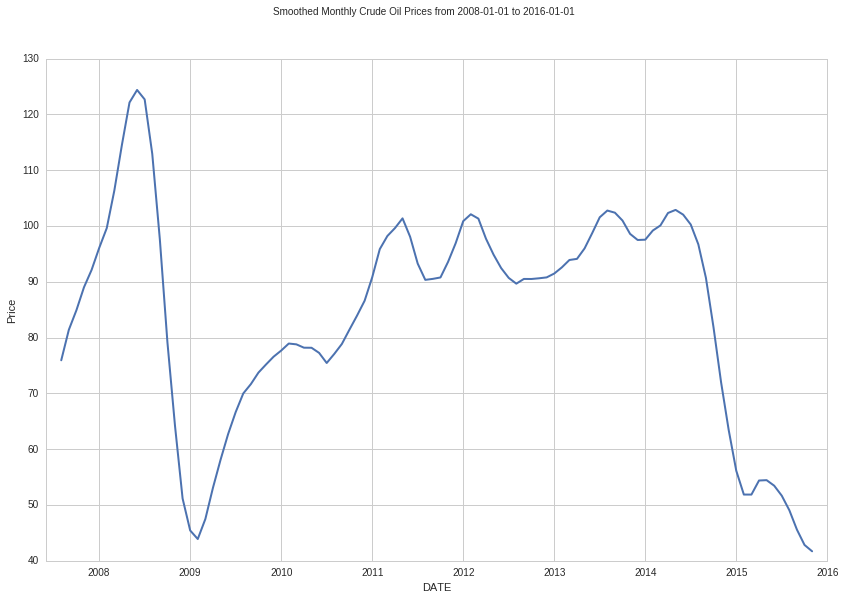

In [4]:
oil_price.plot(linewidth=2)
plt.suptitle('Smoothed Monthly Crude Oil Prices from 2008-01-01 to 2016-01-01')
plt.ylabel('Price')
plt.gcf().set_size_inches(14, 9, forward=True)

In [5]:
# Load, clean and plot the unemployment data for Canada

# Data taken from http://economicdashboard.albertacanada.com/Unemployment

canada_unemp_edb = pd.read_csv('Canada_unemp_rate.csv', index_col=0, parse_dates=True)
canada_unemp_edb = canada_unemp_edb[canada_unemp_edb.index > cutoff]

canada_unemp_edb['AgeGroup'] = canada_unemp_edb['AgeGroup'].astype('category')
canada_unemp_edb['Sex'] = canada_unemp_edb['Sex'].astype('category')

over15 = canada_unemp_edb['AgeGroup'].cat.categories[1]

canada_unemp_males_over15 = \
    canada_unemp_edb[(canada_unemp_edb['Sex'] == 'Males') & (canada_unemp_edb['AgeGroup'] == over15)]

canada_unemp_females_over15 = \
    canada_unemp_edb[(canada_unemp_edb['Sex'] == 'Females') & (canada_unemp_edb['AgeGroup'] == over15)]

del canada_unemp_males_over15['AgeGroup']
del canada_unemp_males_over15['Sex']
del canada_unemp_females_over15['AgeGroup']
del canada_unemp_females_over15['Sex']
    
male_factor = 0.5

canada_unemp_over15 = (canada_unemp_males_over15 * male_factor + 
                       canada_unemp_females_over15 * (1 - male_factor))

canada_unemp_over15 = pd.rolling_mean(canada_unemp_over15, 5, center=True)

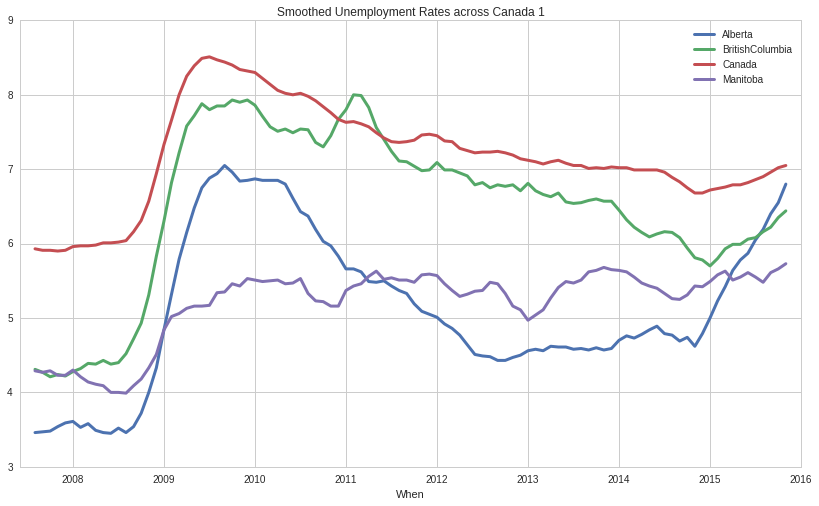

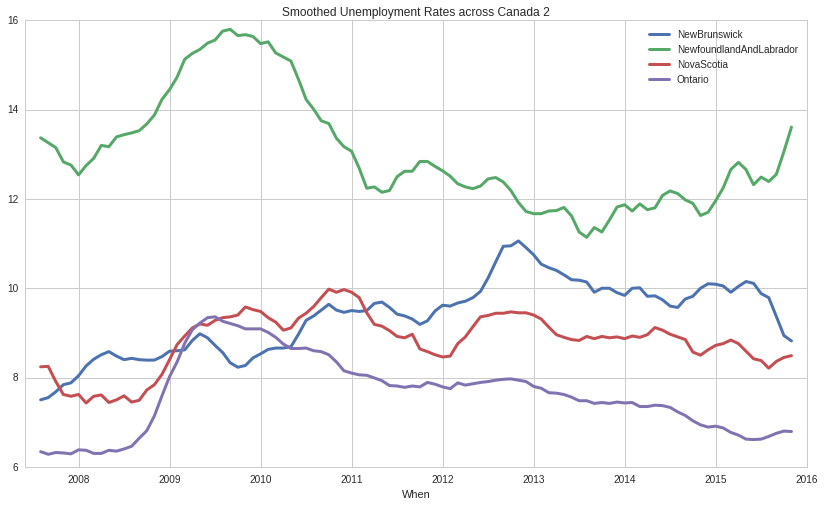

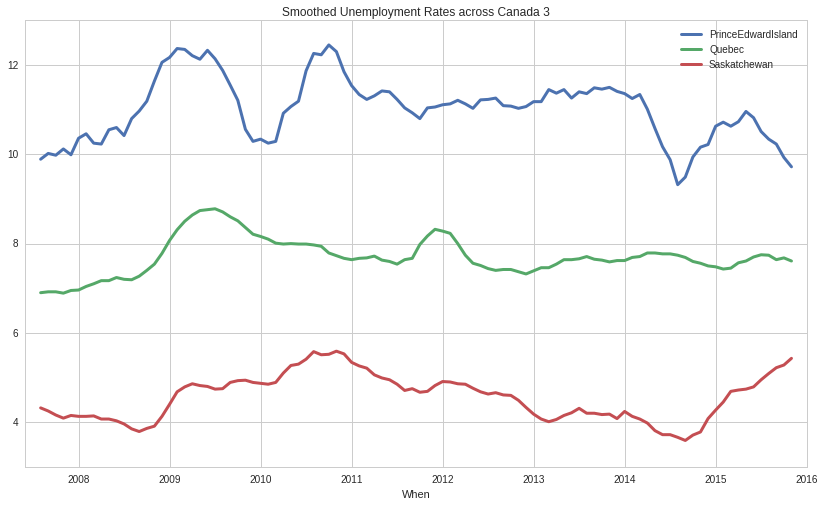

In [6]:
w_in = 14
h_in = 8

canada_unemp_over15.iloc[:, :4].plot(title='Smoothed Unemployment Rates across Canada 1', linewidth=3)
plt.gcf().set_size_inches(w_in, h_in, forward=True)

canada_unemp_over15.iloc[:, 4:8].plot(title='Smoothed Unemployment Rates across Canada 2', linewidth=3)
plt.gcf().set_size_inches(w_in, h_in, forward=True)

canada_unemp_over15.iloc[:, 8:].plot(title='Smoothed Unemployment Rates across Canada 3', linewidth=3)
plt.gcf().set_size_inches(w_in, h_in, forward=True)

In [7]:
# Add oil price shifts to the unemployment dataframe

oilp_vs_unemp = canada_unemp_over15.copy()
unemp_cols = canada_unemp_over15.columns.tolist()
price_cols = []

for i in range(6):
    col_name = 'OilPrice{}'.format(i)
    oilp_vs_unemp = pd.concat([oil_price.shift(i), oilp_vs_unemp], axis=1)
    oilp_vs_unemp.rename(columns = {'VALUE': col_name}, inplace=True)
    price_cols.append(col_name)

oilp_vs_unemp.dropna(inplace=True)
oilp_vs_unemp.head()

,OilPrice5,OilPrice4,OilPrice3,OilPrice2,OilPrice1,OilPrice0,Alberta,BritishColumbia,Canada,Manitoba,NewBrunswick,NewfoundlandAndLabrador,NovaScotia,Ontario,PrinceEdwardIsland,Quebec,Saskatchewan
DATE,,,,,,,,,,,,,,,,,
2008-01-01,75.936,81.392,84.906,89.028,92.124,96.054,3.61,4.28,5.96,4.30,8.04,12.54,7.62,6.38,10.36,6.96,4.13
2008-02-01,81.392,84.906,89.028,92.124,96.054,99.616,3.53,4.32,5.97,4.21,8.26,12.75,7.43,6.37,10.46,7.04,4.13
2008-03-01,84.906,89.028,92.124,96.054,99.616,106.358,3.58,4.39,5.97,4.14,8.41,12.91,7.58,6.30,10.25,7.10,4.14
2008-04-01,89.028,92.124,96.054,99.616,106.358,114.540,3.49,4.38,5.98,4.11,8.51,13.20,7.61,6.30,10.23,7.17,4.07
2008-05-01,92.124,96.054,99.616,106.358,114.540,122.136,3.46,4.43,6.01,4.09,8.58,13.17,7.44,6.37,10.55,7.17,4.07


In [8]:
from pandas import DataFrame
lm_score_df = DataFrame(index=unemp_cols, columns=price_cols)

for unemp_col in unemp_cols:
    for price_col in price_cols:
        lm = linear_model.LinearRegression()
        lm.fit(X=oilp_vs_unemp[[unemp_col]], y=oilp_vs_unemp[price_col])
        model_score = lm.score(X=oilp_vs_unemp[[unemp_col]], y=oilp_vs_unemp[price_col])
        lm_score_df.loc[unemp_col, price_col] = model_score
        
max_idx = lm_score_df.idxmax(axis=1)
max_scr = lm_score_df.max(axis=1)

print(max_idx)
print(max_scr)

Alberta                    OilPrice4
BritishColumbia            OilPrice4
Canada                     OilPrice4
Manitoba                   OilPrice3
NewBrunswick               OilPrice5
NewfoundlandAndLabrador    OilPrice4
NovaScotia                 OilPrice4
Ontario                    OilPrice4
PrinceEdwardIsland         OilPrice2
Quebec                     OilPrice3
Saskatchewan               OilPrice4
dtype: object
Alberta                    0.617549
BritishColumbia            0.190280
Canada                     0.295704
Manitoba                   0.119464
NewBrunswick               0.048681
NewfoundlandAndLabrador    0.260931
NovaScotia                 0.090160
Ontario                    0.152695
PrinceEdwardIsland         0.035050
Quebec                     0.320959
Saskatchewan               0.386699
dtype: float64


/home/matija/Software/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


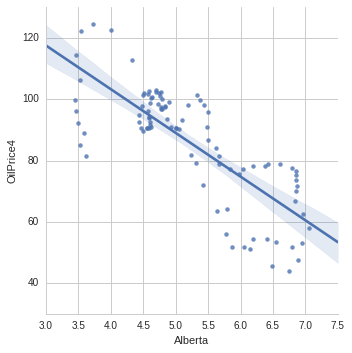

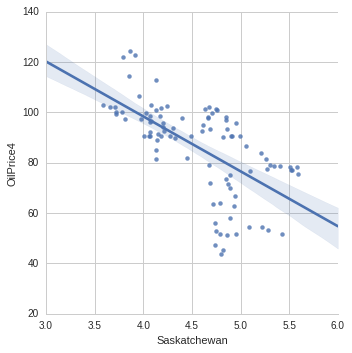

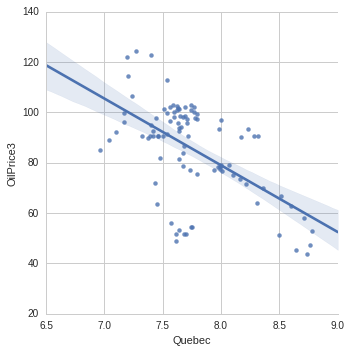

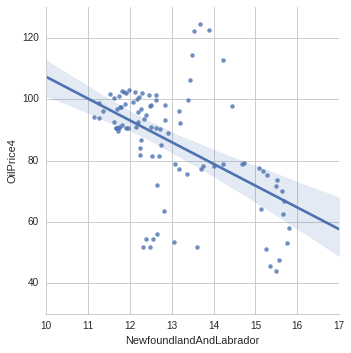

In [9]:
sns.lmplot('Alberta',                 'OilPrice4', data=oilp_vs_unemp)
sns.lmplot('Saskatchewan',            'OilPrice4', data=oilp_vs_unemp)
sns.lmplot('Quebec',                  'OilPrice3', data=oilp_vs_unemp)
sns.lmplot('NewfoundlandAndLabrador', 'OilPrice4', data=oilp_vs_unemp)

In [10]:
prov_mapping = {'CA.YT': 'Yucatan', 
                'CA.BC': 'BritishColumbia', 
                'CA.QC': 'Quebec', 
                'CA.ON': 'Ontario', 
                'CA.MB': 'Manitoba', 
                'CA.NU': 'Nunavut', 
                'CA.NB': 'NewBrunswick', 
                'CA.AB': 'Alberta', 
                'CA.NS': 'NovaScotia', 
                'CA.NL': 'NewfoundlandAndLabrador', 
                'CA.SK': 'Saskatchewan', 
                'CA.NT': 'NorthwestTerritories', 
                'CA.PE': 'PrinceEdwardIsland'}

In [11]:
# Load and reshape the geojson data into the patches format expected by Bokeh

with open('ca-all.geo.json', 'r') as c:
    can_geojson = json.load(c)

provinces = {prov_data['id']: 
                  {'lons': [[coord[0] for coord in polygon]
                           if prov_data['geometry']['type'] == 'Polygon' 
                           else [coord[0] for coord in polygon[0]]
                                for polygon in prov_data['geometry']['coordinates']],
                   'lats': [[coord[1] for coord in polygon]
                           if prov_data['geometry']['type'] == 'Polygon' 
                           else [coord[1] for coord in polygon[0]]
                                for polygon in prov_data['geometry']['coordinates']]}
                         for prov_data in can_geojson['features']}

In [12]:
p = figure(title='Canada Oil Price vs Unemployment', plot_width=800, plot_height=600)
for (prov_id, province) in provinces.items():
    p.patches(province['lons'], province['lats'], fill_color = 'red')
show(p)